# Overview

This notebook provides support for an article at Medium.com.

Initial concepts over at [ComparisonGroupScratchSpace.ipynb](ComparisonGroupScratchSpace).

In [1]:
import pandas as pd
import numpy as np

from math import sqrt
from scipy.spatial import distance
from scipy.stats import zscore

from pandas_profiling import ProfileReport
import seaborn as sns

# Get & Prepare Data

In [2]:
# Use data from US Department of Education IPEDS Surveys
# This data prepared by: https://github.com/adamrossnelson/StataIPEDSAll
location = r'~/documents/ipeds_data/'
dir_info = pd.read_stata(location + 'IPEDSDirInfo02to18.dta')
inst_chs = pd.read_stata(location + 'IPEDSInstChar02to18.dta')

In [3]:
dir_info_17 = dir_info[dir_info['isYr'] == 2017].copy()
inst_chs_17 = inst_chs[inst_chs['isYr'] == 2017].copy()

del dir_info_17['isYr']
del inst_chs_17['isYr']

In [4]:
df = pd.merge(dir_info_17, inst_chs_17, on='unitid')

In [5]:
# Keep a subset of variables only.
# Original dictionary files: 
#   https://nces.ed.gov/ipeds/datacenter/data/HD2017_Dict.zip
#   https://nces.ed.gov/ipeds/datacenter/data/IC2017_Dict.zip
# 
#  unitid   : Unique identificaiotn number.
#  instnm   : Institution name.
#  stabbr   : Institution state abbreviation.
#  sector   : Sector (public, private, 2yr, 4yr, etc.)
#  iclevel  : Two-years, four-yeasr, etc.
#  control  : Public or private institution status.
#  locale   : Urbanicity index.
#  instcat  : Degree-granting category.
#  c18basic : Carnegie classification.
#  instsize : Categorical institution size.
#  longitud : Geographic longidue location.
#  latitude : Geographic latitude location.
#  roomcap  : Residence hall room capacity.
#  roomamt  : Residence hall room fees.
#  boardamt : Dining hall fees.
#  applfeeu : Application fees.
#  applcn   : Count of undergraduate applications.
#  admssn   : Count of undergraduate admissions.
#  enrlft   : Count of full-time enrollment.
#  enrlt    : Count of enrollment.

df = df[['unitid','instnm','stabbr','sector','iclevel',
         'control','locale','instcat','c15basic','instsize',
         'longitud','latitude','roomcap','roomamt','boardamt',
         'rmbrdamt','applfeeu','applcn','admssn','enrlft',
         'enrlt']]

# Define a selectivity index as number of admissions over
# the number of applications. Admission rate.
df['accept'] = df['admssn'] / df['applcn']

# Setting the unitid as the data frame index.
df.set_index('unitid', inplace=True)

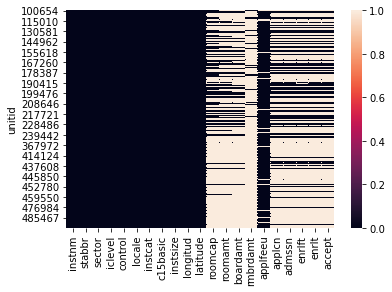

In [6]:
sns.heatmap(df.isna())

In [7]:
# Limit the analysis to public & private 4 year institutions
df = df[(df['sector'] == 'Public, 4-year or above') | \
        (df['sector'] == 'Private not-for-profit, 4-year or above')]
# Limit the analysis to schools with a residence hall capacity.
df = df[df['roomcap'].fillna(-9999) != -9999]
# Limit the analysis to schools that report application data.
df = df[df['applcn'].fillna(-9999) != -9999]

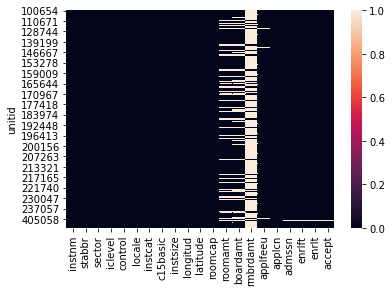

In [8]:
sns.heatmap(df.isna())

In [9]:
df[['roomamt','boardamt']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
roomamt,1238.0,6082.14378,2171.780094,0.0,4600.0,5900.0,7354.5,16675.0
boardamt,1170.0,4597.68547,1193.423839,0.0,3830.0,4581.5,5340.0,8965.0


In [16]:
# Some institutions (n=431) will report combined room & board.
# Estimate room amount as 60% of combined amount.
# Estimate board amount as 40% of combined amount.
df['roomamtX'] = [y * .6 if x == -99 else x for x, y in \
                  zip(df['roomamt'].fillna(-99), df['rmbrdamt'])]
df['boardamtX'] = [y * .4 if x == -99 else x for x, y in \
                   zip(df['boardamt'].fillna(-99), df['rmbrdamt'])]
# Replace missing application fee as zero? Free to apply?
df['applfeeu'].fillna(0, inplace=True)

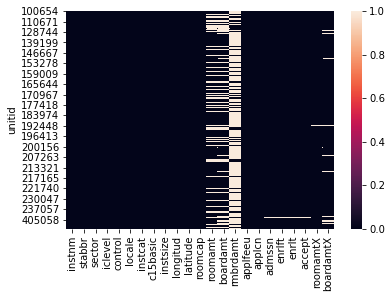

In [17]:
sns.heatmap(df.isna())

In [14]:
# Display remaining observations with missing admission free information
df[df['admssn'].fillna(-9999) == -9999][['instnm','applfeeu','admssn',
                                         'enrlft','enrlt','accept']]

,instnm,applfeeu,admssn,enrlft,enrlt,accept
unitid,,,,,,
142957,American Islamic College,25.0,NaN,NaN,NaN,NaN
245777,Bais Medrash Elyon,0.0,NaN,NaN,NaN,NaN
441609,Yeshiva Shaarei Torah of Rockland,100.0,NaN,NaN,NaN,NaN


In [ ]:
# Drop these three observations.
df.dropna(inplace=True)

In [ ]:
sns.heatmap(df.isna())

In [ ]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [ ]:
profile.to_file("ipeds_data_sample_2017_report.html")

## Define Functions

In [ ]:
def jaccard(data, ref, cols, verbose=False):
    '''Calculates Jarcard index for all observations
    relative to the referenced observation. Returns a list
    of Jaccardian distances.
    
    data = A dataframe.
    ref  = A reference observation. Specify by the axis 0 index.
    cols = A set of comparison columns.'''

    try:
        ref_observation = data[cols].iloc[ref]
    except IndexError:
        ref_observation = data[cols].loc[ref]
        ref = df.index.get_loc(ref)
    
    distances = []
    length = len(cols) 
        
    for row in range(len(data)):
        comp_observation = data[cols].iloc[row]
        matches = sum([1 if x == y else 0 for x, y in zip(ref_observation,
                                                          comp_observation)])
        distances.append(1 - (matches / length))
    
    if verbose:
        print('Returning {} distances.'.format(len(distances)))
        print('Minimum distance = 0 : {}'.format(min(distances) == 0))
        print('Maximum distance = {}'.format(max(distances)))
        print('Mean distance = {}'.format(sum(distances) / len(distances)))
        
    return(distances)

# Goal: Count the number of matching dimensions among two observations
def hamming(data, ref, cols):
    '''Calculates Hamming distance for all observations
    relative to the referenced observation. Returns a list
    of hamming distances.
    
    data = A dataframe.
    ref  = A reference observation. Specify by the axis 0 index.
    cols = A set of comparison columns.'''

    if type(ref) == int:
        ref = ref
    if type(ref) == str:
        ref = df.index.get_loc(ref)

    distances = []
    ref_observation = data[cols].iloc[ref]
    for row in range(len(data)):
        comp_observation = data[cols].iloc[row]
        matches = sum([1 if x == y else 0 for x, y in zip(comp_observation,
                                                          ref_observation)])
        distances.append(matches)
    return(distances)

def euclidian(data, ref, cols, verbose=False):
    '''Calculates Euclidian distance for all observations
    relative to the referenced observation. Returns a list
    of euclidian distances.
    
    data = A dataframe.
    ref  = A reference observation. Specify by the axis 0 index.
    cols = A set of comparison columns.'''
        
    try:
        ref_observation = data[cols].apply(zscore).iloc[ref]
    except IndexError:
        ref_observation = data[cols].apply(zscore).loc[ref] 
        ref = df.index.get_loc(ref)
    
    distances = []
    for row in range(len(data)):
        comp_observation = data[cols].apply(zscore).iloc[row]
        dist = distance.euclidean(ref_observation, comp_observation)
        distances.append(dist)
        
    if verbose:
        print('Returning {} distances.'.format(len(distances)))
        print('Minimum distance = 0 : {}'.format(min(distances) == 0))
        print('Maximum distance = {}'.format(max(distances)))
        print('Mean distance = {}'.format(sum(distances) / len(distances)))
    
    return(distances)

# Case Sudies

## University of Wisconsin-Madison

### Euclidian

In [ ]:
# Review Madison's profile based on this data.
df.loc[240444]

In [ ]:
continous_cols = ['longitud','latitude','roomcap','roomamt',
                  'applfeeu','accept','enrlft']
df['WI_euclidian'] = euclidian(data=df, ref=240444, 
                               cols=continous_cols,
                               verbose=True)

In [ ]:
# Verify that Wisconsin is distance zero from itself
print(df.loc[240444]['WI_euclidian'] == 0)
print(df.loc[240444]['WI_euclidian'])

In [ ]:
df.sort_values(by='WI_euclidian', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['WI_euclidian']].head(n=10)

### Jacardian

In [ ]:
# Review Madison's profile based on this data.
df.loc[240444]

In [ ]:
# Designate selective as those above median
df['isSelect'] = df['accept'] > df['accept'].median()
# Designate large as those enrolling above median
df['isBig'] = df['enrlft'] > df['enrlft'].median()

In [ ]:
cat_cols = ['stabbr','sector','locale','c15basic',
            'isSelect','isBig']
df['WI_jacardian'] = jaccard(data=df, ref=240444, 
                             cols=cat_cols,
                             verbose=True)

In [ ]:
df.sort_values(by=['WI_jacardian','WI_euclidian'], inplace=True)
df[['instnm','stabbr'] + cat_cols + \
   ['WI_euclidian','WI_jacardian']].head(n=10)

## University of North Carolina Charlotte

In [ ]:
df.loc[199139]

In [ ]:
continous_cols = ['longitud','latitude','roomcap','roomamt',
                  'applfeeu','accept','enrlft']
df['CLT_euclidian'] = euclidian(data=df, ref=199139, 
                                cols=continous_cols,
                                verbose=True)

In [ ]:
# Verify that Wisconsin is distance zero from itself
print(df.loc[199139]['CLT_euclidian'] == 0)
print(df.loc[199139]['CLT_euclidian'])

In [ ]:
df.sort_values(by='CLT_euclidian', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['CLT_euclidian']].head(n=10)

In [ ]:
continous_cols = ['roomcap','roomamt',
                  'applfeeu','accept','enrlft']
df['CLT_euclidian'] = euclidian(data=df, ref=199139, 
                                cols=continous_cols,
                                verbose=True)

In [ ]:
df.sort_values(by='CLT_euclidian', inplace=True)
df[['instnm','stabbr'] + continous_cols + ['CLT_euclidian']].head(n=10)